# <center>Data Cleaning for Smart Buoy Dataset </center>

In this notebook we focus on five primary stages for data cleansing:
- Part I: Managing unrecorded data gaps that span several months.
- Part II: Handle missing values 
- Part III: Standardize the datetime index by evenly spacing it

## Contents:
* Import libraries 
* Load Dataset
* Analyze missing values
* Data Filtering
* Part I: Manage the Data Gap
* Part II: Handle Missing Values
* Part III: Standardize the Datetime Index

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)

## Load Dataset
* The first row of dataset presents the columns measurement units, so we skip this row. 
* The time column is string, so we parse/convert it to datetime64 data type as we load the dataset.
* We downcast the dtate types for memory efficiency (Explained in previous section EDA).

In [ ]:
df = pd.read_csv('../input/wavebnetwork/WaveBNetwork.csv',
                 skiprows=[1],
                 parse_dates=['time'])
df = df.rename(columns={'SignificantWaveHeight':'SWH',
                        'SeaTemperature':'SeaTemp',
                        'MeanCurDirTo':'MeanCurDir',
                        'MeanCurSpeed':'MeanCurSpd'})

#Set index
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

# Type downcasting
def set_dtypes(df):
    
    df['station_id'] = df['station_id'].astype('category')
    df['instrument'] = df['instrument'].astype('category')
    
    df['PeakPeriod'] = df['PeakPeriod'].astype('float32')
    df['UpcrossPeriod'] = df['UpcrossPeriod'].astype('float32')
    df['SeaTemp'] = df['SeaTemp'].astype('float32')
    df['THmax'] = df['THmax'].astype('float32')
    df['MeanCurSpd'] = df['MeanCurSpd'].astype('float32')
    
    return df

df = set_dtypes(df)

df.head()

,longitude,latitude,station_id,instrument,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,SeaTemp,Hmax,THmax,MeanCurDir,MeanCurSpd
time,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,-10.149796,54.228027,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,10.53,291.60000,5.532,139.4,NaN,229.0,9.85,NaN,NaN
2020-01-01 00:00:00+00:00,-9.268117,53.228966,SmartBay Wave Buoy,Datawell WaveRider 4,9.09,242.81319,3.100,42.0,8.24,81.0,8.93,318.94507,0.216
2020-01-01 00:03:00+00:00,-10.149796,54.228027,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,10.53,293.90000,5.510,136.2,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:05:00+00:00,-9.268117,53.228966,SmartBay Wave Buoy,Datawell WaveRider 4,NaN,NaN,NaN,NaN,8.24,NaN,NaN,NaN,NaN
2020-01-01 00:07:00+00:00,-10.149796,54.228027,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,10.53,287.40000,5.678,139.3,NaN,NaN,NaN,NaN,NaN


## Analyze Missing Values

Before we filter the data for the target station, we visualize the entire dataset's missing values to identify any potential patterns within the gaps in the data.


Missing Values Matrix on the Whole Dataset


<Axes: >

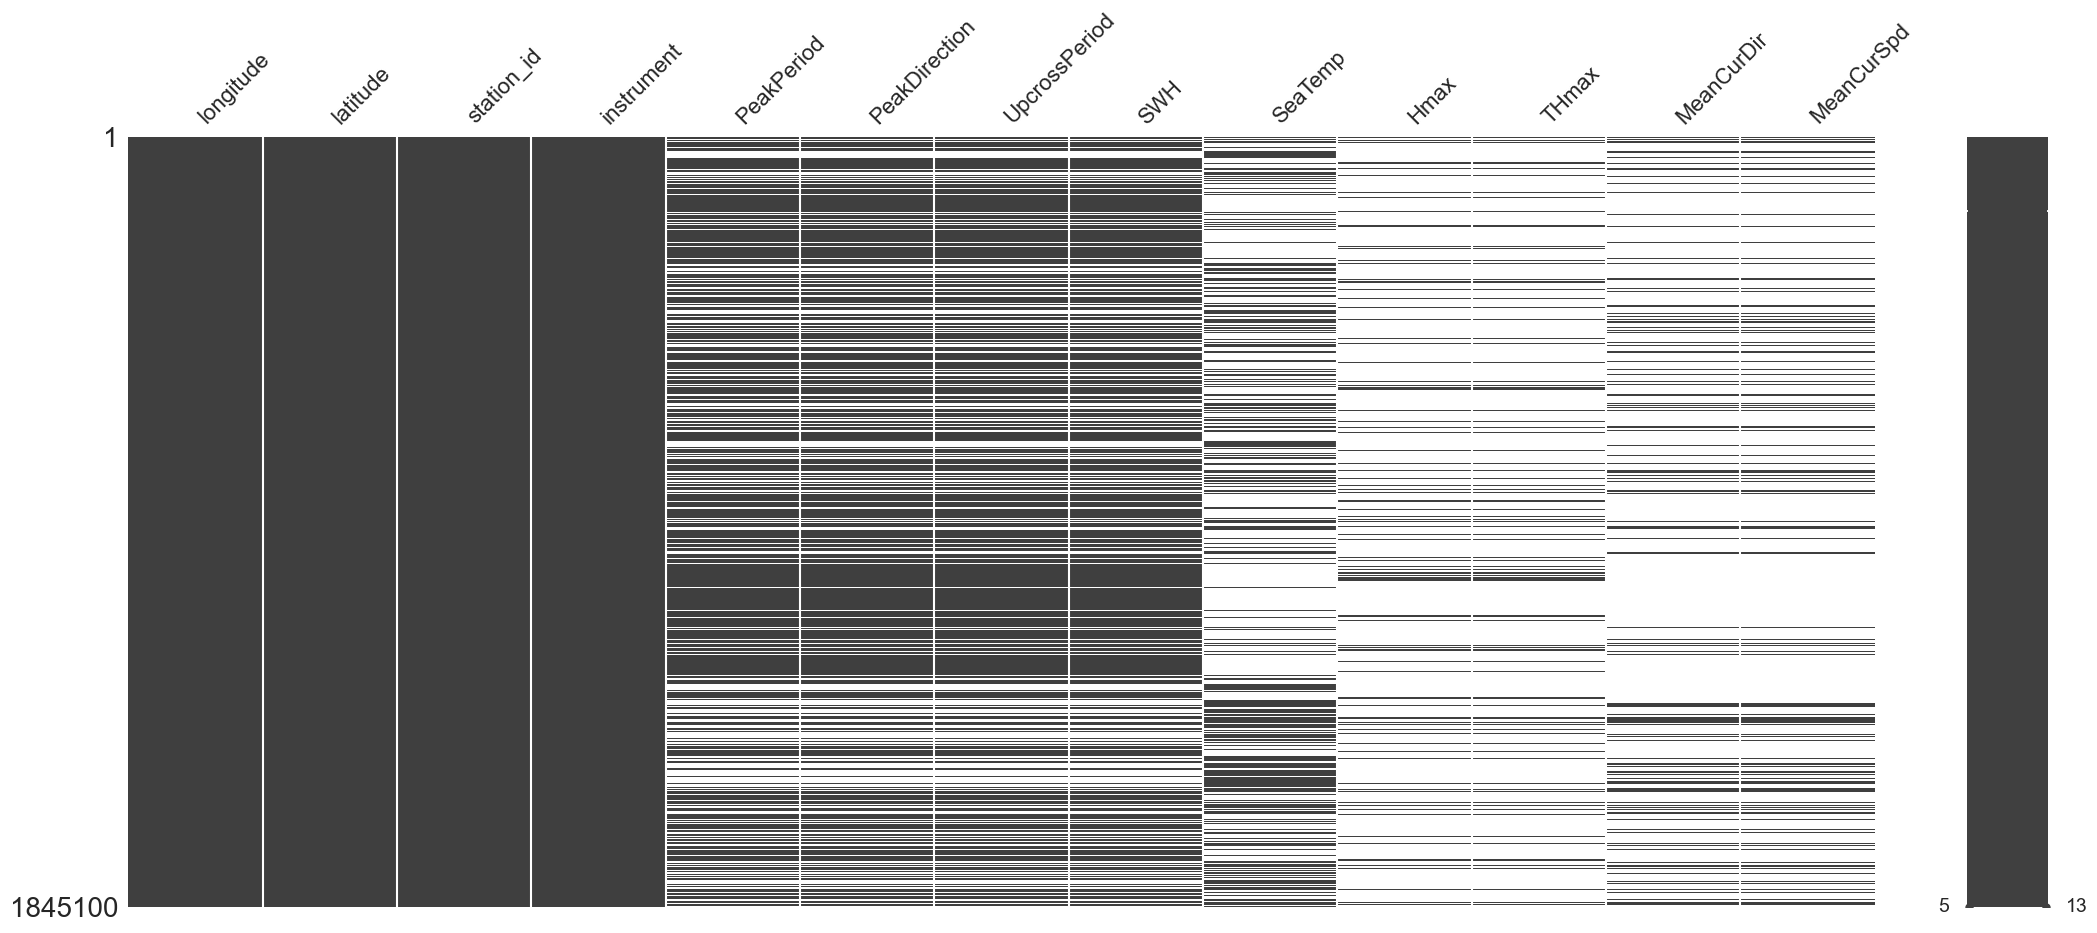

In [ ]:
import missingno as msno
print(f'\nMissing Values Matrix on the Whole Dataset')
msno.matrix(df)

* The missing value patterns appear consistent for <b>PeakPeriod</b>, <b>PeakDirection</b>, <b>UpcrossPeriod</b>, and <b>SWH</b> variables. 
* <b>Hmax</b> and <b>THmax</b> exhibit identical patterns of missing data.
* <b>MeanCurDir</b> and <b>MeanCurSpd</b> follow the same missing data patterns.

## Data Filtering

From EDA section we know <b>MeanCurDir</b>, <b>MeanCurSpd</b>, and <b>SeaTemp</b> variables are stored only in some stations using an instrument distinct from the one employed at our target station. Hence, Before filtering the data by target station we'll check if any of these variables are usefull for our forcasting model and import them to our target station.</br>

From EDA section also Heatmap showed us there isn't a significant correlation between our target variable and these features:
* MeanCurDir correlation is 0.1
* MeanCurSpd correlation is 0.03
* SeaTemp correlation is 0.24

Consequently, we opt to exclude these three variables from our current analysis.

In [ ]:
# save a copy of the original dataset before filtering the data
df_orig = df.copy()

In [ ]:
df = df.drop(['MeanCurDir', 'MeanCurSpd', 'SeaTemp'], axis=1)

In [ ]:
# Filter the data to the target station
p_station = 'AMETS Berth B Wave Buoy'
df = df.loc[df['station_id'] == p_station].copy()


Missing Values Matrix for "AMETS Berth B Wave Buoy" station


<Axes: >

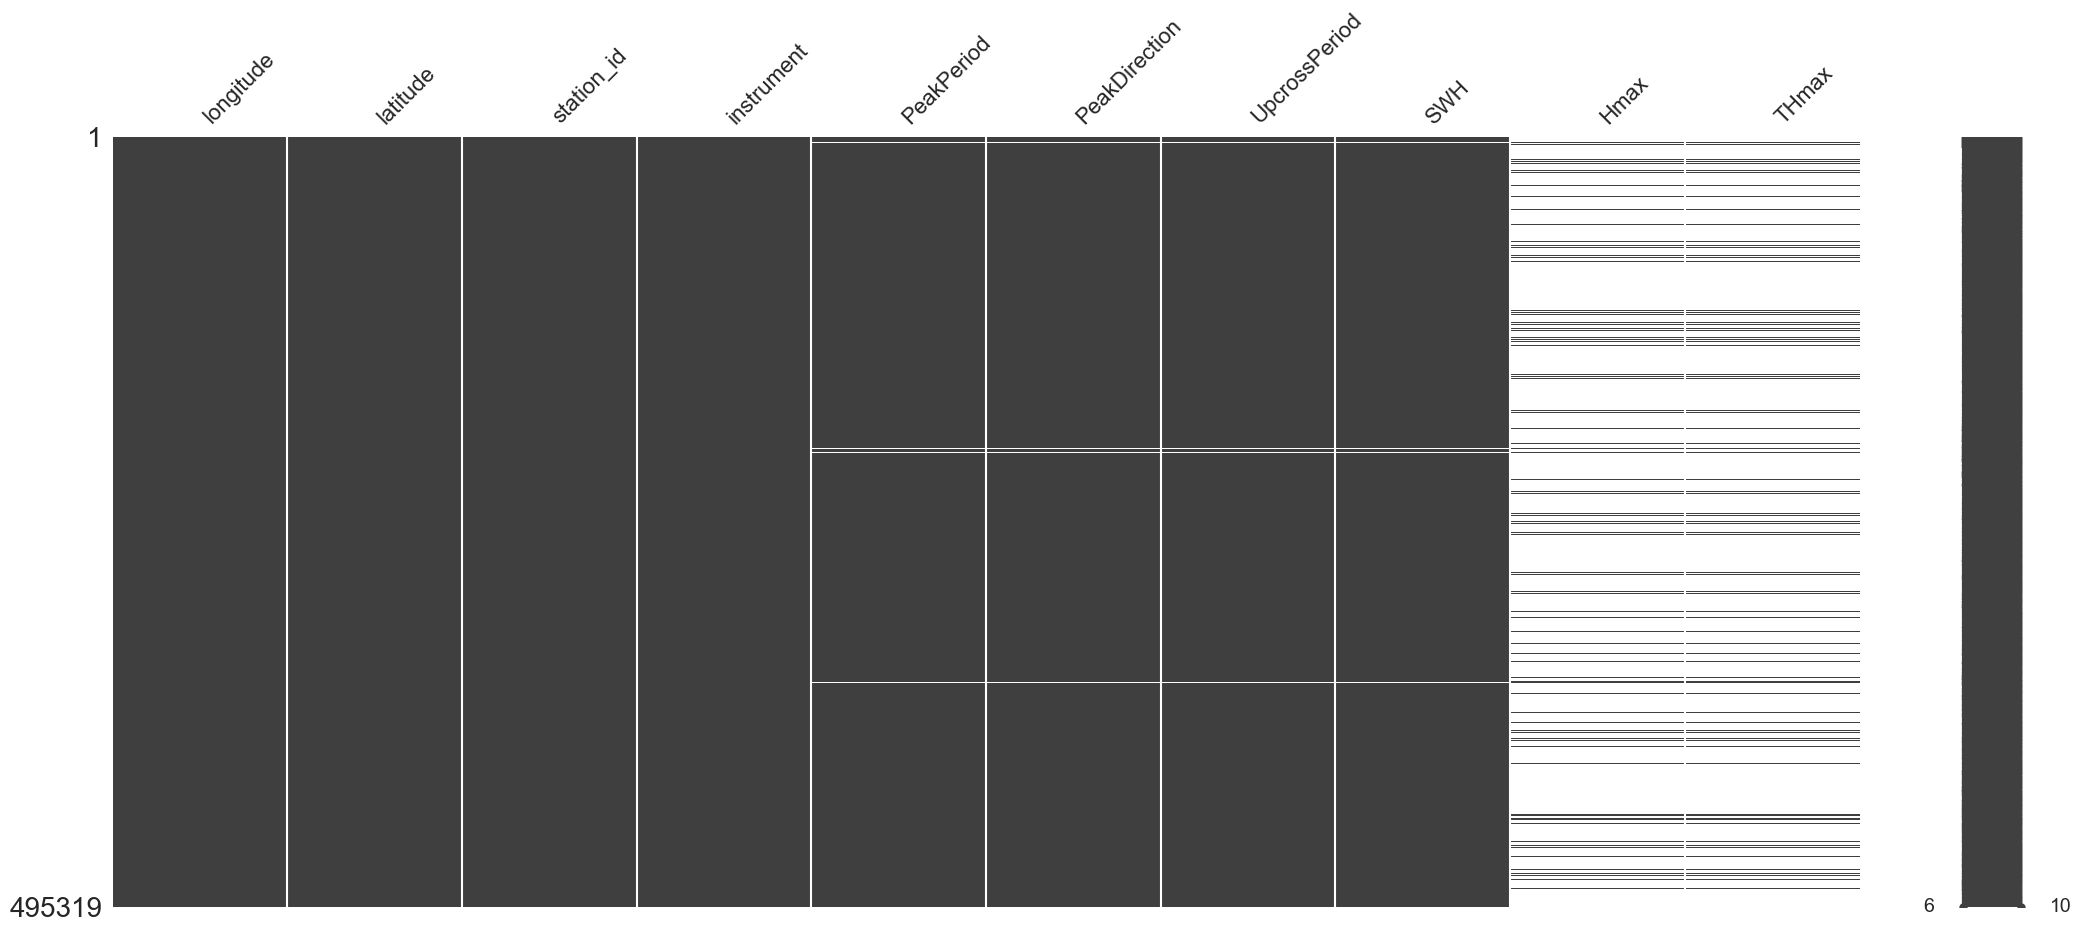

In [ ]:
print(f'\nMissing Values Matrix for "{p_station}" station')
msno.matrix(df)

In [ ]:
# Drop variables that are consistant for the target station
df = df.drop(['longitude', 'latitude', 'station_id', 'instrument'], axis=1)

In [ ]:
def find_null_counts(df):
    print(f'Total number of rows: {df.shape[0]}')
    for col in df.columns:
        c = len(df.loc[df[col].isnull()])
        if c != 0:
            print(f'number of nulls in {col}: {len(df.loc[df[col].isnull()])} ({len(df.loc[df[col].isnull()])/df.shape[0]*100:.0f}%)')

In [ ]:
find_null_counts(df)

Total number of rows: 495319
number of nulls in PeakPeriod: 4483 (1%)
number of nulls in PeakDirection: 4483 (1%)
number of nulls in UpcrossPeriod: 4483 (1%)
number of nulls in SWH: 4483 (1%)
number of nulls in Hmax: 439746 (89%)
number of nulls in THmax: 439746 (89%)


In [ ]:
consecutive_nulls = df['SWH'].isnull().astype(int).groupby(df['SWH'].notnull().astype(int).cumsum()).cumsum()
print(f'Maximum number of consecutive null rows: {consecutive_nulls.max()}')

Maximum number of consecutive null rows: 25


* There are significant number of missing values for Hmax and THmax.
* Maximum number of consecutive null rows is 25. The index is not standardized yet which means this number doesn't include the time gaps missing in the index.(more details on this in the next section) 

##  Part I: Manage the Data Gap

* There are 3 missing periods (gaps) in the target time series.
* According to EDA section, station "AMETS Berth B Wave Buoy" series is very similar to the target station  series
* The first gap in 2020 also happened in the similar station "AMETS Berth A Wave Buoy".
* The later gaps in 2022 have recordings for "AMETS Berth A Wave Buoy" station.
* Possible approaches:
    * For 2020 gap, we'll skip data to the end of this gap. We have a lot of data and the amount of data before this gap is very small (0.04% of data).
    * For 2022 gaps, we'll build a model to predict missing values based on the values of the similar station. We'll use a decision tree.

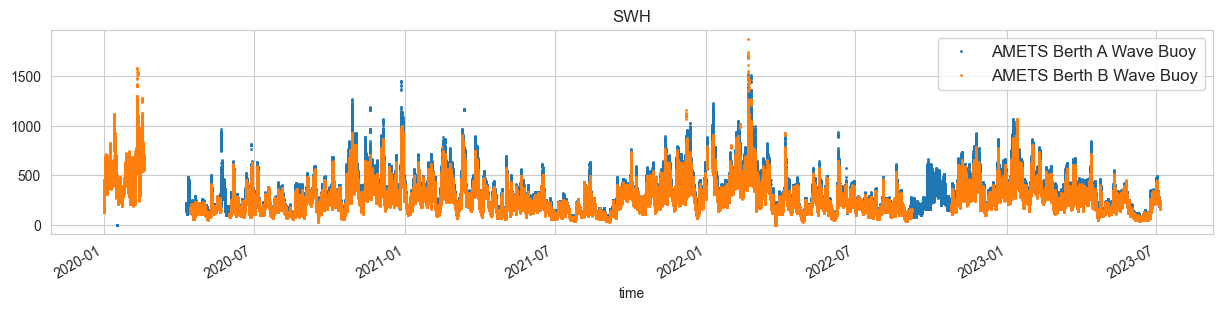

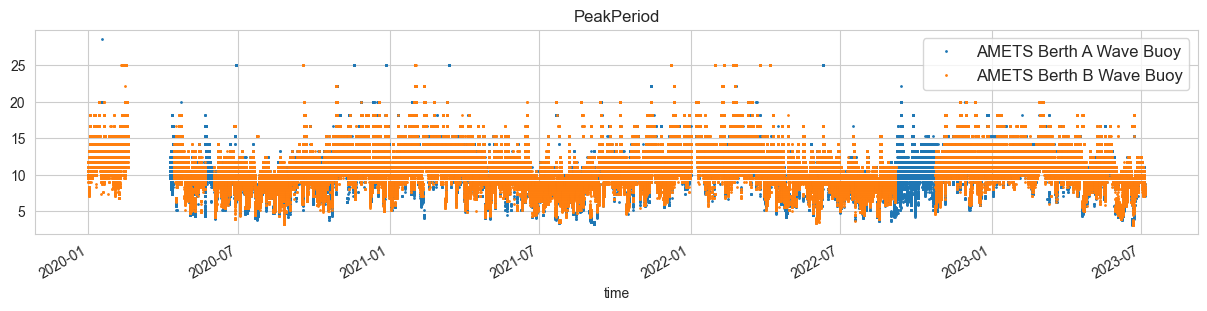

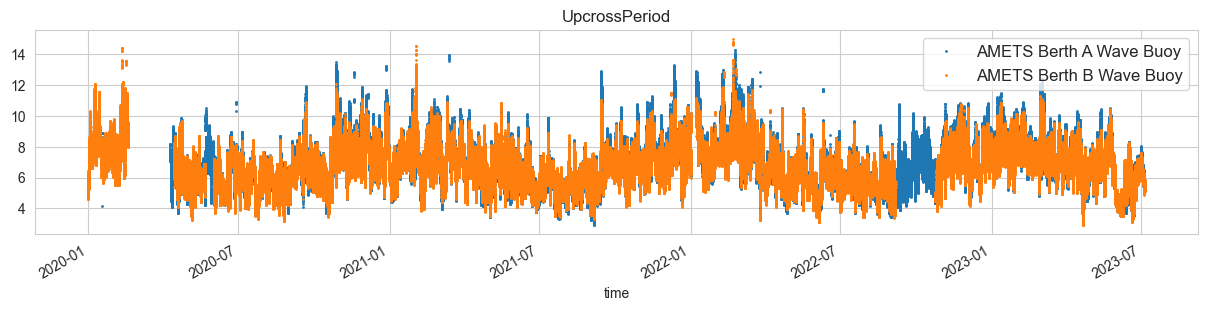

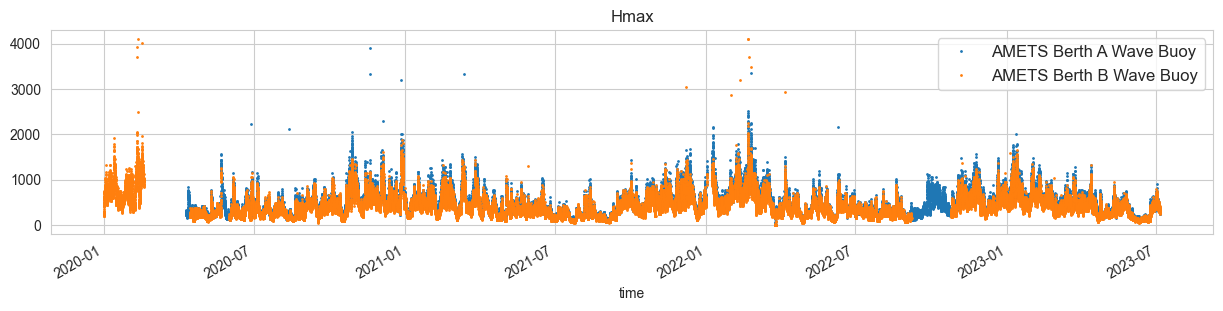

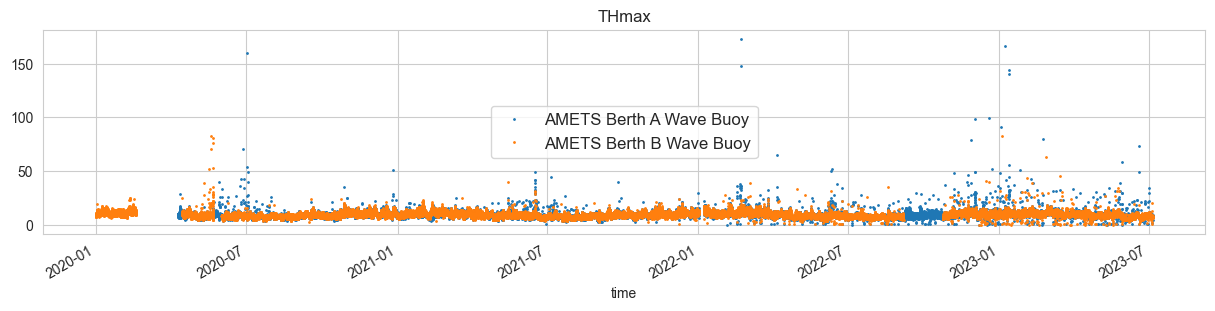

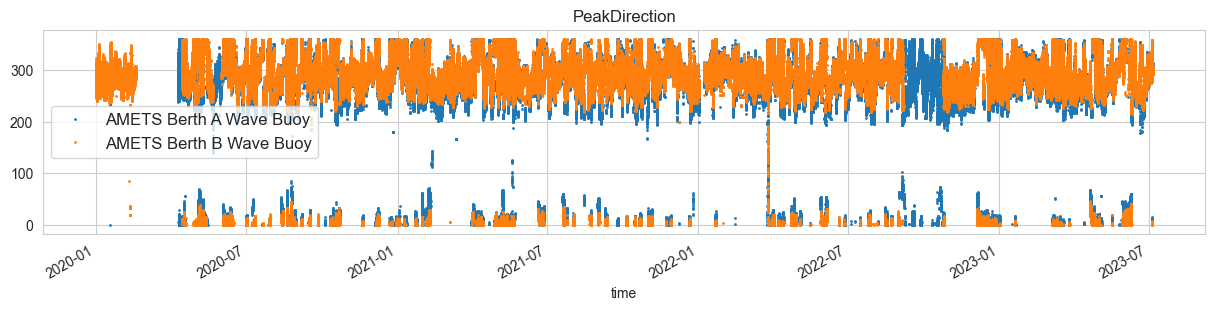

In [ ]:
variables=['SWH','PeakPeriod','UpcrossPeriod', 'Hmax','THmax', 'PeakDirection']
for variable in variables:
    df_orig.loc[df_orig['station_id']=='AMETS Berth A Wave Buoy'][variable] \
    .plot(figsize=(15,3),
          style='.',
          color=color_pal[0],
          markersize=2,
          label='AMETS Berth A Wave Buoy',
          title=variable)
    df_orig.loc[df_orig['station_id']=='AMETS Berth B Wave Buoy'][variable] \
    .plot(figsize=(15,3),
          style='.',
          color=color_pal[1],
          markersize=2,
          label='AMETS Berth B Wave Buoy')
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
# remove the data before 2020 gap

# 2020 missing period timedate
gap_start = '2020-02-18 19:23'
gap_end = '2020-04-14 11:56' # 55 days 16 hours 33 minutes

df = df[(df.index > gap_end)]
df_orig = df_orig[(df_orig.index > gap_end)]

In [ ]:
find_null_counts(df)

Total number of rows: 474374
number of nulls in PeakPeriod: 4031 (1%)
number of nulls in PeakDirection: 4031 (1%)
number of nulls in UpcrossPeriod: 4031 (1%)
number of nulls in SWH: 4031 (1%)
number of nulls in Hmax: 421132 (89%)
number of nulls in THmax: 421132 (89%)


### Visualizing the Goal

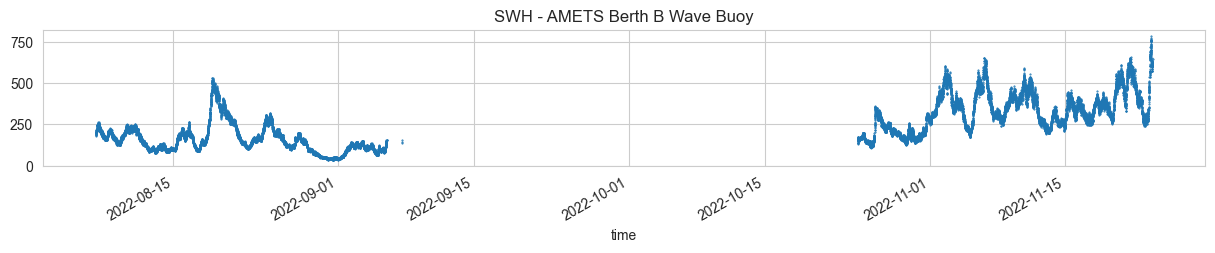

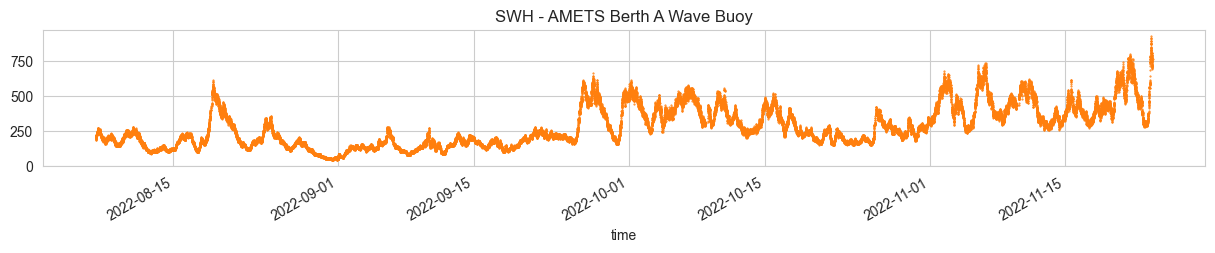

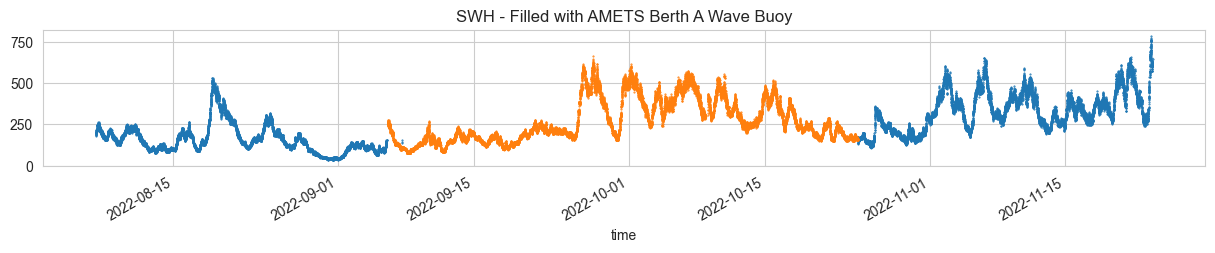

In [ ]:
# 2022 Missing period timedate
gap_start = '2022-09-06 03:00'
gap_end = '2022-10-24 14:14'

df[(df.index > '2022-08-07') & (df.index < '2022-11-24')]['SWH'].plot(figsize=(15,2), 
                                                                      style='.', 
                                                                      color=color_pal[0],
                                                                      markersize=1,
                                                                      title='SWH - AMETS Berth B Wave Buoy')
plt.show()

df_orig[(df_orig['station_id']=='AMETS Berth A Wave Buoy') 
      & (df_orig.index > '2022-08-07') & (df_orig.index < '2022-11-24')]['SWH'].plot(figsize=(15,2),
                                                                                     style='.',
                                                                                     color=color_pal[1],
                                                                                     markersize=1,
                                                                                     title='SWH - AMETS Berth A Wave Buoy')
plt.show()

ax = df[(df.index > '2022-08-07') & (df.index < '2022-11-24')]['SWH'].plot(figsize=(15,2), 
                                                                           style='.', 
                                                                           color=color_pal[0],
                                                                           markersize=1,
                                                                           title='SWH - Filled with AMETS Berth A Wave Buoy')
df_orig[(df_orig['station_id']=='AMETS Berth A Wave Buoy') 
      & (df_orig.index >= gap_start) & (df_orig.index <= gap_end)]['SWH'].plot(ax = ax,
                                                                               style='.',
                                                                               color=color_pal[1],
                                                                               markersize=1,
                                                                               title='')
plt.show()


### Predict Missing Period Using Similar Series
We want to train a decision tree to capture the relationship between station "AMETS Berth A Wave Buoy" SWH values and the target station "AMETS Berth B Wave Buoy" SWH values. Using this model we'll predict the missing gap in our target station. The model will predict all missing values through out the whole time series. It's important to note that the two series do not have identical index. <br>

Due to a significant correlation between our target station and the predictor station, we can effectively train this model using only the predictor station.

In [ ]:
df_orig2 = df.copy()

In [ ]:
gap1_start = '2022-09-07 13:44'
gap1_end = '2022-10-24 14:14' # 47 days 30 minutes

gap2_start = '2020-05-21 17:23'
gap2_end = '2020-06-01 10:38'  # 10 days 17 hours 15 minutes (includes some missing index and some null values)

gap3_start = "2022-09-06 00:10" 
gap3_end = "2022-09-07 13:50" # 1 day 13 hours 40 minute
   
# For this gap the darta is missing in both stations
#gap4_start = '2022-01-01 13:43'
#gap4_end = '2022-01-07 12:00'

In [ ]:
# Find time difference
pd.to_datetime(gap1_end)-pd.to_datetime(gap1_start)

Timedelta('47 days 00:30:00')

In [ ]:
find_null_counts(df)

Total number of rows: 474374
number of nulls in PeakPeriod: 4031 (1%)
number of nulls in PeakDirection: 4031 (1%)
number of nulls in UpcrossPeriod: 4031 (1%)
number of nulls in SWH: 4031 (1%)
number of nulls in Hmax: 421132 (89%)
number of nulls in THmax: 421132 (89%)


In [ ]:
# Generate a dataset that includes a column for variable SWH corresponding to each 2 stations.

variable = 'SWH'
base = df_orig[df_orig['station_id'].isin(['AMETS Berth A Wave Buoy','AMETS Berth B Wave Buoy'])].copy()
base = base[['station_id','PeakPeriod', 'UpcrossPeriod', 'SWH', 'Hmax', 'THmax', 'PeakDirection']]
base = base.reset_index().set_index(['time','station_id'])[variable].unstack('station_id').copy()
    
varA = f'{variable}A' #predictor
varB = f'{variable}B' #target
base = base.rename(columns = {'AMETS Berth A Wave Buoy':varA,
                          'AMETS Berth B Wave Buoy': varB})   

# remove nulls from the predictor series 
base = base[base[varA].notna()] 

base.loc[base[varB].isnull(),'isMissing']=True
base.loc[base[varB].notnull(),'isMissing']=False # 13% prediction size

base

station_id,SWHA,SWHB,isMissing
time,,,
2020-04-14 11:57:00+00:00,153.2,NaN,True
2020-04-14 12:03:00+00:00,154.0,135.7,False
2020-04-14 12:07:00+00:00,159.3,140.5,False
2020-04-14 12:10:00+00:00,154.5,139.1,False
2020-04-14 12:13:00+00:00,157.6,141.1,False
...,...,...,...
2023-07-05 20:40:00+00:00,207.0,NaN,True
2023-07-05 20:48:00+00:00,205.6,NaN,True
2023-07-05 20:55:00+00:00,207.1,NaN,True


In [ ]:
# Predict missing values based on other series values.

train = base.loc[base['isMissing']==False]
test = base.loc[base['isMissing']==True]

FEATURES = [varA]
TARGET = varB

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

from sklearn.tree import DecisionTreeRegressor

# Train a decision tree regressor on the non-missing values
tree = DecisionTreeRegressor(random_state = 0)
tree.fit(X_train, y_train)

# Use the trained tree to predict the missing values
base.loc[base['isMissing'], varB] = tree.predict(X_test)

In [ ]:
base

station_id,SWHA,SWHB,isMissing
time,,,
2020-04-14 11:57:00+00:00,153.2,139.489831,True
2020-04-14 12:03:00+00:00,154.0,135.700000,False
2020-04-14 12:07:00+00:00,159.3,140.500000,False
2020-04-14 12:10:00+00:00,154.5,139.100000,False
2020-04-14 12:13:00+00:00,157.6,141.100000,False
...,...,...,...
2023-07-05 20:40:00+00:00,207.0,186.290090,True
2023-07-05 20:48:00+00:00,205.6,187.244762,True
2023-07-05 20:55:00+00:00,207.1,187.425893,True


In [ ]:
# Insert the predicted gap index and values
def fill_gap(df, base, variable, varB, gap_start, gap_end):
    
    df = df.copy()
    predicted_gap = base[(base.index > gap_start) & (base.index < gap_end)][varB]

    # use outer merge to create the missing index according to the similar series
    df = df.merge(predicted_gap, how='outer', left_index = True, right_index=True)
    
    # fill missing values with predicted values
    df.loc[(df.index > gap_start) & (df.index < gap_end), variable] = \
    df.loc[(df.index > gap_start) & (df.index < gap_end)][varB].copy()
    
    df = df.drop(varB, axis=1)
    
    return df

In [ ]:
df = fill_gap(df, base, variable, varB, gap1_start, gap1_end)
df = fill_gap(df, base, variable, varB, gap2_start, gap2_end)
df = fill_gap(df, base, variable, varB, gap3_start, gap3_end)

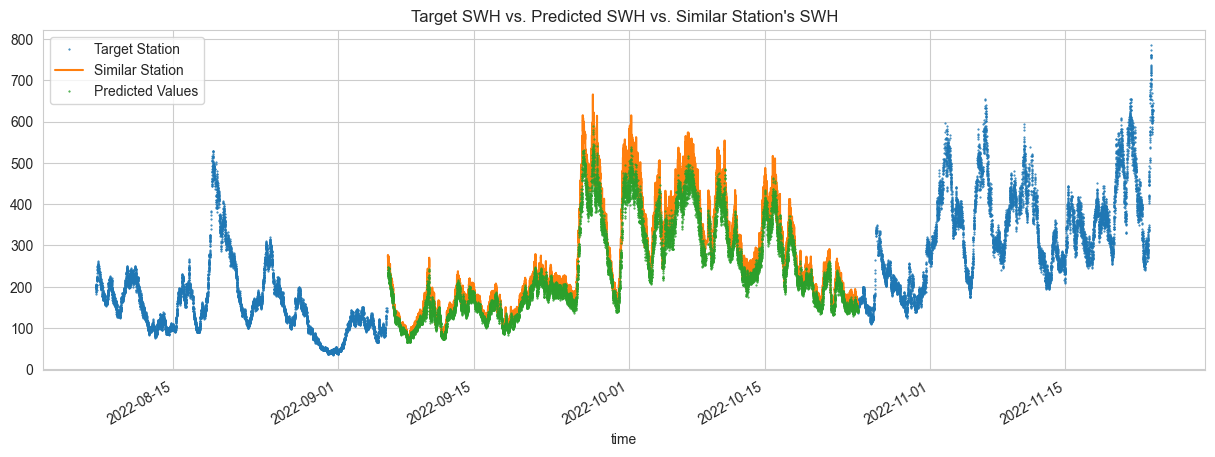

In [ ]:
# Visualize target station with predicted values for one of the gaps
ax = train[(train.index > '2022-08-07') 
               & (train.index < '2022-11-24')][varB].plot(figsize=(15,5),
                                                                  style='.',
                                                                  color = color_pal[0],
                                                                  markersize=1,
                                                                  label='Target Station',
                                                                  title="Target SWH vs. Predicted SWH vs. Similar Station's SWH")
# Similar station
base[(base.index > gap_start) 
   & (base.index < gap_end)][varA].plot(ax = ax,
                                        style='-',
                                        color=color_pal[1],
                                        markersize=1,
                                        label='Similar Station')
# Predicted values
df[(df.index > gap_start) &(df.index < gap_end)][variable].plot(ax=ax,
                                                                 style='.',
                                                                 color = color_pal[2],
                                                                 markersize=1,
                                                                 label='Predicted Values')

plt.legend()
plt.show()


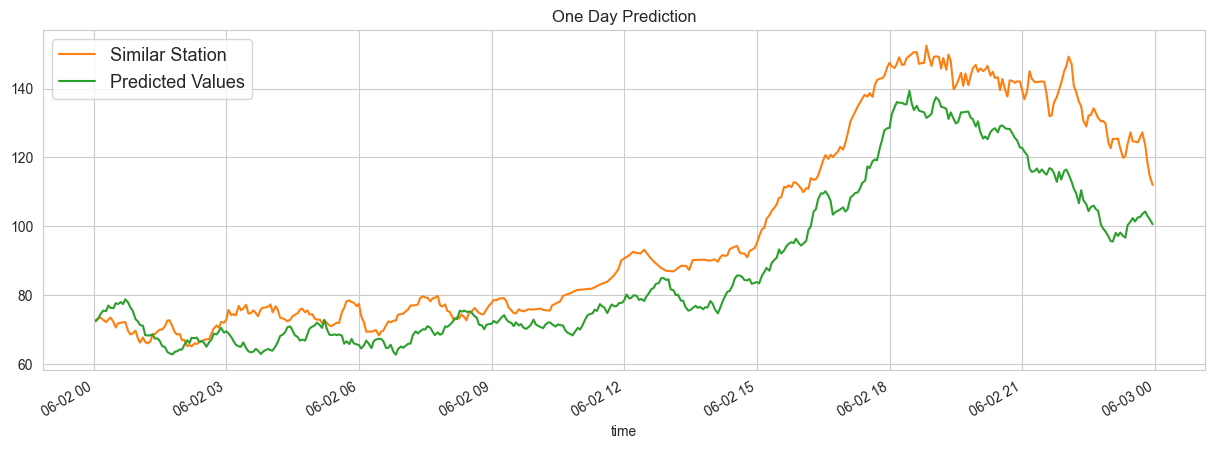

In [ ]:
# Visualize one day od prediction vs.the predictor series
ax =base[(base.index > '2022-06-02') 
       & (base.index < '2022-06-03')][varA].plot(figsize=(15,5),
                                                 style='-',
                                                 color=color_pal[1],
                                                 markersize=1,
                                                 label='Similar Station',
                                                 title='One Day Prediction')
# Predicted values
df[(df.index > '2022-06-02') &(df.index < '2022-06-03')][variable].plot(ax=ax,
                                                                     style='-',
                                                                     color = color_pal[2],
                                                                     markersize=1,
                                                                     label='Predicted Values')
plt.legend(fontsize=13)
plt.show()

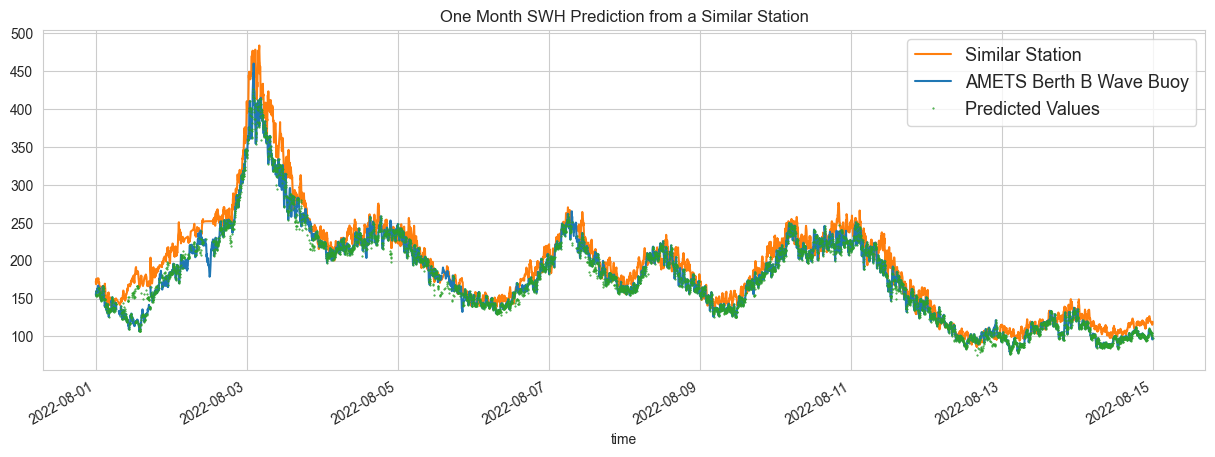

In [ ]:
# Visualize predicted values vs. the predictor station vs. the target station on part of training data
ax =base[(base.index > '2022-08-01') 
       & (base.index < '2022-08-15')][varA].plot(figsize=(15,5),
                                                 style='-',
                                                 color=color_pal[1],
                                                 markersize=1,
                                                 label='Similar Station',
                                                 title='One Month SWH Prediction from a Similar Station')

# Target station
df_orig.loc[(df_orig['station_id']=='AMETS Berth B Wave Buoy')
           & (df_orig.index >'2022-08-01')
                & (df_orig.index < '2022-08-15')][variable].plot(ax=ax, figsize=(15,5),
                                                                             style='-',
                                                                             color=color_pal[0],
                                                                             markersize=1,
                                                                             label='AMETS Berth B Wave Buoy')

# Predicted values
base[(base.index > '2022-08-01') &(base.index < '2022-08-15')][varB].plot(ax=ax,
                                                                     style='.',
                                                                     color = color_pal[2],
                                                                     markersize=1,
                                                                     label='Predicted Values')
plt.legend(fontsize=13)
plt.show()


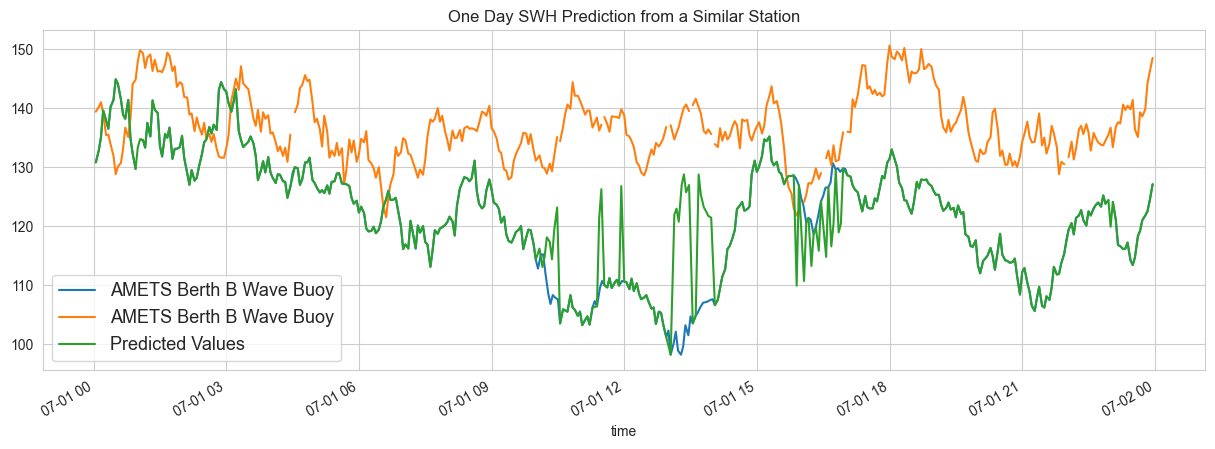

In [ ]:
# Visualize part of data that the predictor and the targe variables are not quite similar.
ax = df_orig.loc[(df_orig['station_id']=='AMETS Berth B Wave Buoy')
                 & (df_orig.index >'2022-07-01')
                 & (df_orig.index < '2022-07-02')]['SWH'].plot(figsize=(15,5),
                                                               style='-',
                                                               color=color_pal[0],
                                                               markersize=1,
                                                               label='AMETS Berth B Wave Buoy',
                                                               title='One Day SWH Prediction from a Similar Station')
df_orig.loc[(df_orig['station_id']=='AMETS Berth A Wave Buoy')
            & (df_orig.index >'2022-07-01')
            & (df_orig.index < '2022-07-02')][variable].plot(ax=ax,
                                                          style='-',
                                                          color=color_pal[1],
                                                          markersize=1,
                                                          label='AMETS Berth B Wave Buoy')


base[(base.index > '2022-07-01') 
     & (base.index < '2022-07-02')][varB].plot(ax=ax,
                                                 style='-',
                                                 color = color_pal[2],
                                                 markersize=1,
                                                 label='Predicted Values')

plt.legend(fontsize=13)
plt.show()


### Turn above steps into a function to apply on other variables

In [ ]:
def fill_missing_values(df, variable):
    # Generate a dataset that includes a column for variable SWH corresponding to each station.
    
    gap1_start = '2022-09-07 13:44'
    gap1_end = '2022-10-24 14:14'

    gap2_start = '2020-05-21 17:23'
    gap2_end = '2020-06-01 10:38'

    gap3_start = "2022-09-06 00:10" 
    gap3_end = "2022-09-07 13:50"

    df = df.copy()
    
    base = df_orig[df_orig['station_id'].isin(['AMETS Berth A Wave Buoy','AMETS Berth B Wave Buoy'])].copy()
    base = base[['station_id','PeakPeriod', 'UpcrossPeriod', 'SWH', 'Hmax', 'THmax', 'PeakDirection']]
    base = base.reset_index().set_index(['time','station_id'])[variable].unstack('station_id').copy()

    varA = f'{variable}A' #predictor
    varB = f'{variable}B' #target
    base = base.rename(columns = {'AMETS Berth A Wave Buoy':varA,
                              'AMETS Berth B Wave Buoy': varB})   

    # remove nulls from the predictor series 
    base = base[base[varA].notna()] 

    base.loc[base[varB].isnull(),'isMissing']=True
    base.loc[base[varB].notnull(),'isMissing']=False # 13% prediction size
    
    # Predict missing values based on other series values.

    train = base.loc[base['isMissing']==False]
    test = base.loc[base['isMissing']==True]

    FEATURES = [varA]
    TARGET = varB

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    from sklearn.tree import DecisionTreeRegressor

    # Train a decision tree regressor on the non-missing values
    tree = DecisionTreeRegressor(random_state = 0)
    tree.fit(X_train, y_train)

    # Use the trained tree to predict the missing values
    base.loc[base['isMissing'], varB] = tree.predict(X_test)
    
    # Insert the predicted gap index and values
    
    df = fill_gap(df, base, variable, varB, gap1_start, gap1_end)
    df = fill_gap(df, base, variable, varB, gap2_start, gap2_end)
    df = fill_gap(df, base, variable, varB, gap3_start, gap3_end)

    return df

In [ ]:
# Fill gap periods for other SWH relevant variables
variables = ['UpcrossPeriod', 'PeakDirection', 'PeakPeriod', 'Hmax', 'THmax']

for variable in variables:
    df = fill_missing_values(df, variable)

In [ ]:
find_null_counts(df)

Total number of rows: 498684
number of nulls in PeakPeriod: 4514 (1%)
number of nulls in PeakDirection: 4514 (1%)
number of nulls in UpcrossPeriod: 4514 (1%)
number of nulls in SWH: 4514 (1%)
number of nulls in Hmax: 442680 (89%)
number of nulls in THmax: 442680 (89%)


After filling the gaps, we observe an additional 483 null records in the number of missing values. This discrepancy is a result of the indexes of those two series not aligning perfectly.

## Part II: Handle Missing Values

### SWH and Relevant Features

In [ ]:
df['SWH'] = df['SWH'].interpolate()
df['PeakPeriod'] = df['PeakPeriod'].interpolate()
df['PeakDirection'] = df['PeakDirection'].interpolate()
df['UpcrossPeriod'] = df['UpcrossPeriod'].interpolate()

### Hmax, THmax

SWH: sea surface wave significant height in cm<br>
Hmax: sea surface wave height of highest wave in cm<br>
THmax: sea_ surface wave period of highest wave in second<br>

* If Hmax is missing, THmax will be missing too. It's visible in the matrix too.
* For Hmax we employ the "ffill" method to fill in the missing values by using the most recent recorded value.
* For THmax we fill in the missing vakues by 0. When there's no record for THmax, it implies that no new Hmax value was recorded within that period. Thus, assigning a time period of 0 is a sensible representation of this scenario.

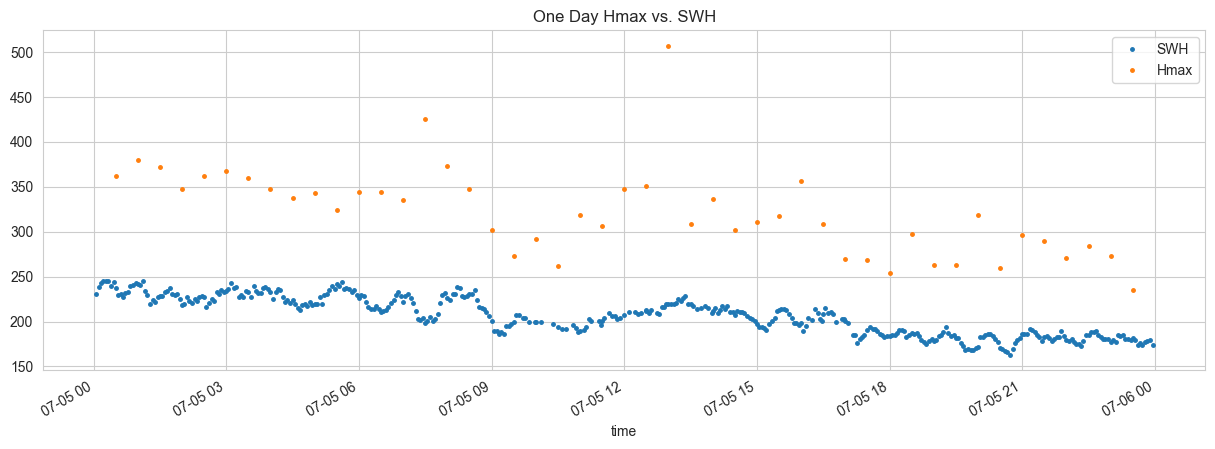

In [ ]:
df[(df.index > '2022-07-05') & (df.index < '2022-07-06')][['SWH','Hmax']].plot(style='.', 
                                                                               figsize=(15,5), 
                                                                               markersize=5,
                                                                               title='One Day Hmax vs. SWH')
plt.show()

In [ ]:
df['Hmax'] = df['Hmax'].ffill()

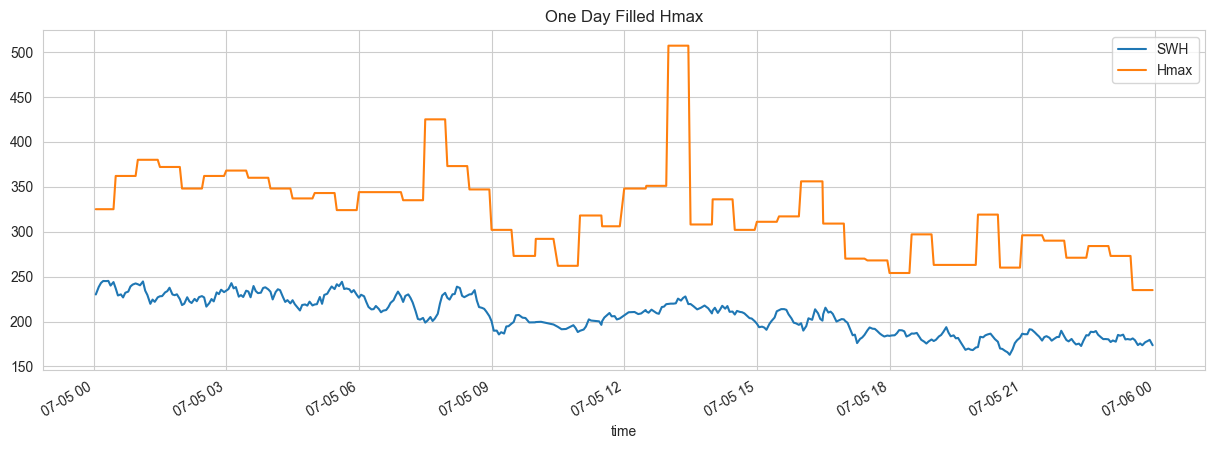

In [ ]:
df[(df.index > '2022-07-05') & (df.index < '2022-07-06')][['SWH','Hmax']].plot(style='-', 
                                                                               figsize=(15,5), 
                                                                               markersize=2,
                                                                               title='One Day Filled Hmax')
plt.show()

In [ ]:
df['THmax'] = df['THmax'].fillna(0)

<Axes: >

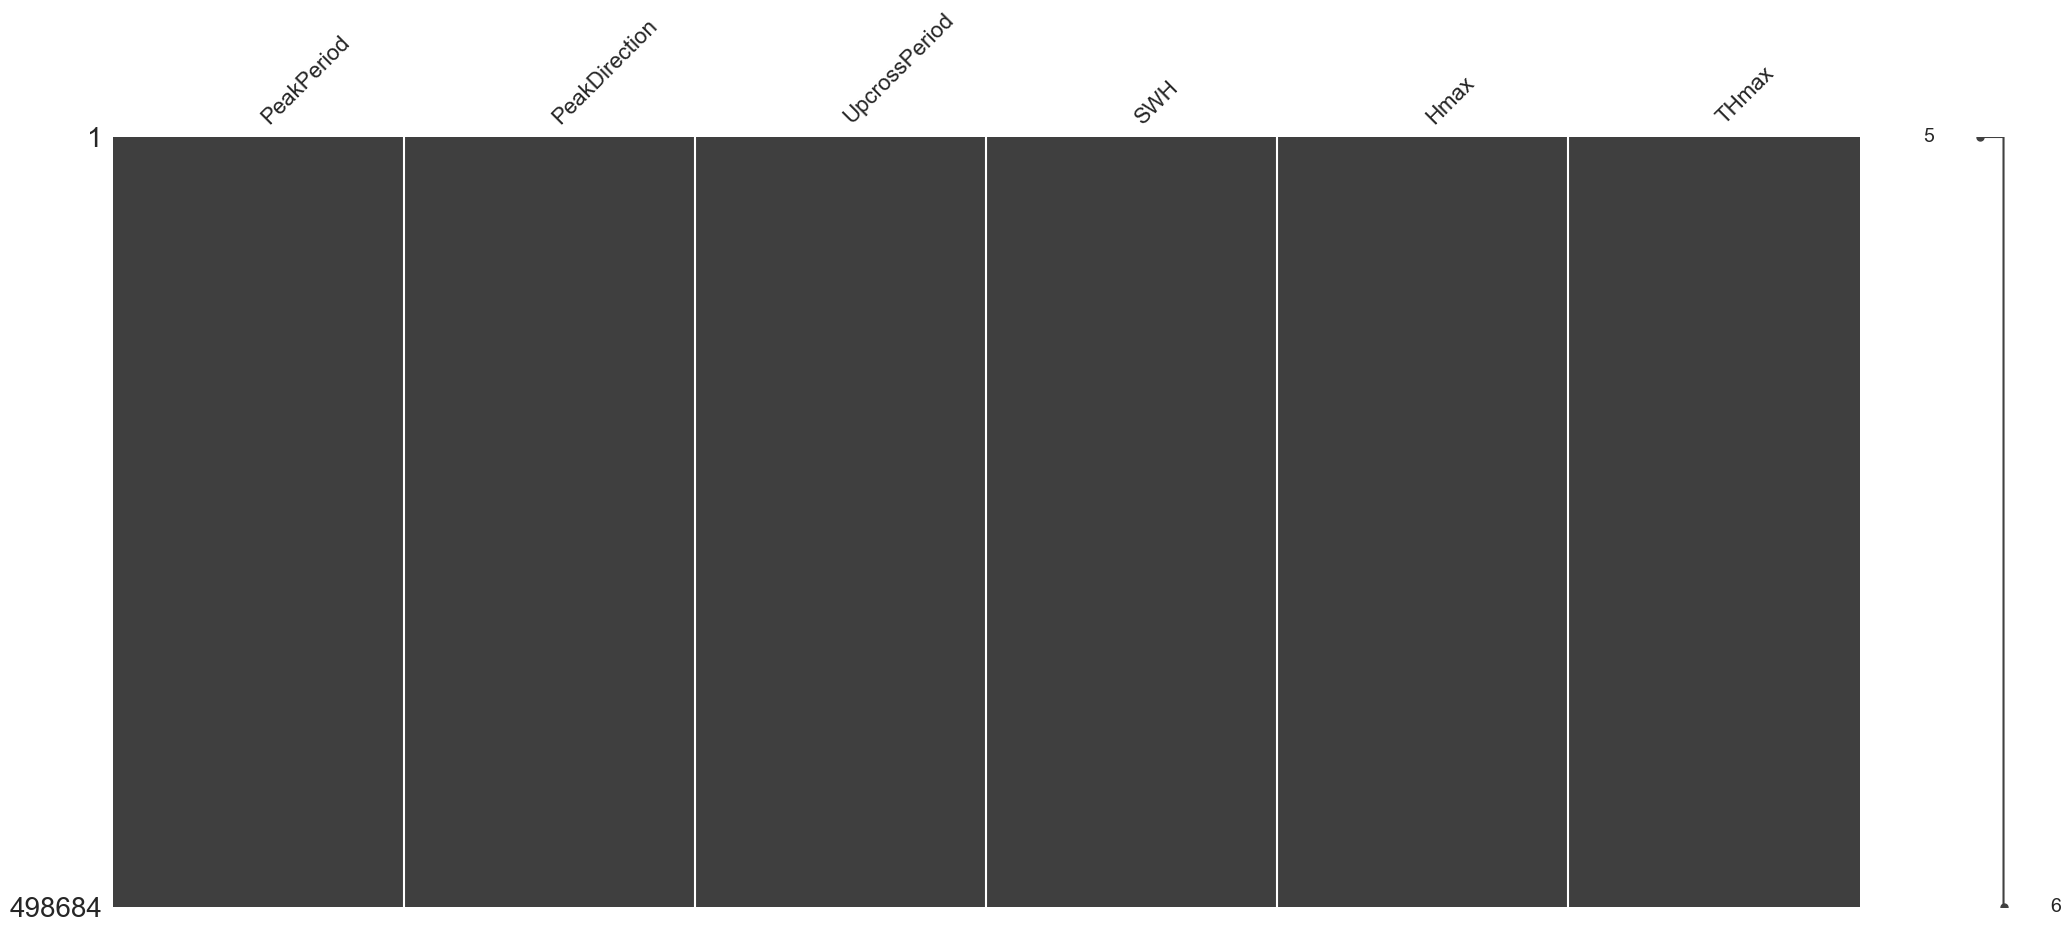

In [ ]:
msno.matrix(df)

In [ ]:
df_orig3 = df.copy()

## Part III: Standardize the Datetime Index

* Transform the index into an evenly spaced arrangement.
* Eliminate any duplicate values in the index.
* Ensure that the newly created evenly spaced index does not contain any missing values.

In [ ]:
print(f'There is {len(df.loc[df.index.duplicated()])} duplicated index in dataset.')

There is 0 duplicated index in dataset.


In [ ]:
# Find recording time differences
timeDiff = df[1:].index-df[0:-1].index
timeDiff.value_counts()

time
0 days 00:03:00    328365
0 days 00:04:00    164743
0 days 00:05:00      1131
0 days 00:06:00      1002
0 days 00:02:00       880
                    ...  
0 days 01:17:00         1
0 days 01:03:00         1
0 days 00:39:00         1
0 days 01:38:00         1
0 days 03:58:00         1
Name: count, Length: 61, dtype: int64

In [ ]:
print(f'{(326093+163565)/len(df) * 100:.2f}% of the data is recorded every 3 or 4 minutes.')

98.19% of the data is recorded every 3 or 4 minutes.


* There are 62 distinct time intervals between the recordings, and most of these intervals (about 98.32%) take place after 3 or 4 minutes. 
* In the dataset, the pattern of time intervals follows a sequence of (3, 3, 4). Therefore, to standardize the index, a reasonable resampling size of 10 (3+3+4) minutes is chosen.
* We also make an hourly spaced index which is useful in the next section, stationarity and decomposition. We ultimately will use the hourly spaced index. 

In [ ]:
# add time difference as a column to dataset

def add_time_diff(df):
    df = df.copy()
    timeDiff = df.reset_index()['time'].to_frame()
    timeDiff['delay'] = (timeDiff['time'].diff().dt.total_seconds())
    timeDiff = timeDiff.set_index('time')
    df['delay'] = timeDiff['delay'].copy()
    df = df.iloc[1:]
    df.loc[:,'delay'] = (df['delay']/60)
    df['delay'] = df.delay.astype('int32')
    return df

# add_time_diff(df)

#### Create 10 Minute Spaced Index

In [ ]:
# Create a 10-min new index. Skip first index to get indexes every 10 minute of an hour.
new_index = pd.date_range(start =df.index[1], end =df.index.max(), freq ='10min')

In [ ]:
df_m = df.reindex(new_index)
df_m.index.names = ['time']

In [ ]:
find_null_counts(df_m)

Total number of rows: 169534
number of nulls in PeakPeriod: 5360 (3%)
number of nulls in PeakDirection: 5360 (3%)
number of nulls in UpcrossPeriod: 5360 (3%)
number of nulls in SWH: 5360 (3%)
number of nulls in Hmax: 5360 (3%)
number of nulls in THmax: 5360 (3%)


Generation the new standard index create 5360 new null rows which is only about 3% of the whole dataset.

#### Options:
* 1- keep only the data at 10 minutes intervals without resampling
* 2- take the mean of all data exists with that 10 minutes and replace it with the data at 10 minute intervals (new index)
* 3- make the index as 5 minutes intervals and for 5minutes indexes insert the mean of the two 3 min values.

We pick the first approach

In [ ]:
consecutive_nulls = df_m['SWH'].isnull().astype(int).groupby(df_m['SWH'].notnull().astype(int).cumsum()).cumsum()
print(f'Maximum number of consecutive null rows: {consecutive_nulls.max()}')

Maximum number of consecutive null rows: 853


In [ ]:
df_orig[(df_orig['station_id']=='AMETS Berth B Wave Buoy')
       &(df_orig.index >= '2022-01-01 13:43')
       &(df_orig.index <= '2022-01-07 12:00')]

,longitude,latitude,station_id,instrument,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,SeaTemp,Hmax,THmax,MeanCurDir,MeanCurSpd
time,,,,,,,,,,,,,
2022-01-01 13:43:00+00:00,-10.149796,54.228027,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,15.38,253.6,9.341,602.2,NaN,NaN,NaN,NaN,NaN
2022-01-07 12:00:00+00:00,-10.149796,54.228027,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,NaN,NaN,NaN,NaN,NaN,1129.0,16.27,NaN,NaN


* The longest consecutive nulls is 853 rows which represent 5 days and a few hours.
* We interpolate these nulls since they are not significant amount.

In [ ]:
df_m['SWH'] = df_m['SWH'].interpolate()
df_m['PeakPeriod'] = df_m['PeakPeriod'].interpolate()
df_m['PeakDirection'] = df_m['PeakDirection'].interpolate()
df_m['UpcrossPeriod'] = df_m['UpcrossPeriod'].interpolate()

In [ ]:
df_m['Hmax'] = df_m['Hmax'].ffill()
df_m['THmax'] = df_m['THmax'].fillna(0)

In [ ]:
# storing cleaned dataset:
df_m.to_pickle('../input/wavebnetwork/Cleaned_10Minute_Data.sav')

In [ ]:
# reading the dataset:
#imported_df = pd.read_pickle('../input/wavebnetwork/Cleaned_Data.sav')

#### Create Hourly Spaced Index

In [ ]:
# Create an hourly new index 
df_h = df.resample('H').mean().copy()

In [ ]:
find_null_counts(df_h)

Total number of rows: 28257
number of nulls in PeakPeriod: 224 (1%)
number of nulls in PeakDirection: 224 (1%)
number of nulls in UpcrossPeriod: 224 (1%)
number of nulls in SWH: 224 (1%)
number of nulls in Hmax: 225 (1%)
number of nulls in THmax: 224 (1%)


In [ ]:
df_h['SWH'] = df_h['SWH'].interpolate()
df_h['PeakPeriod'] = df_h['PeakPeriod'].interpolate()
df_h['PeakDirection'] = df_h['PeakDirection'].interpolate()
df_h['UpcrossPeriod'] = df_h['UpcrossPeriod'].interpolate()

In [ ]:
df_h['Hmax'] = df_h['Hmax'].ffill()
df_h['THmax'] = df_h['THmax'].fillna(0)

In [ ]:
# Delete the first row which ffill could not fill
df_h = df_h.dropna()

In [ ]:
# storing cleaned dataset:
df_h.to_pickle('../input/wavebnetwork/Cleaned_Hourly_Data.sav')